In [64]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.set_default_dtype(torch.float32)
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [65]:
class Net1(nn.Module):
    def __init__(self, num_classes=2):
        super(Net1, self).__init__()
        input_channels = 3
        width_mult = 1.0
        self.out_channels = 16
        self.features = [nn.Conv2d(input_channels, self.out_channels, kernel_size=3, stride=2, padding=1, bias=False),
                         nn.BatchNorm2d(self.out_channels),
                         nn.Hardswish(inplace=True)]
        #The network structure is modeled after MobileNetV3
        self.bottlenecks = [
            (3, 16, 3, 2),
            (3, 24, 3, 2)
        ]
        for t, c, n, s in self.bottlenecks:
            c = int(c * width_mult)
            for i in range(n):
                hidden_dim = int(round(self.out_channels * t))
                self.features.append(self._bottleneck(self.out_channels, c, hidden_dim, s if i == 0 else 1))
                self.out_channels = c
        self.features = nn.Sequential(*self.features)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(c, 96),
            nn.Hardswish(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(96, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _bottleneck(self, in_channels, out_channels, hidden_dim, stride):
        layers = []
        if hidden_dim != in_channels:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.Hardswish(inplace=True)
            ])
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.Hardswish(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        return nn.Sequential(*layers)

In [66]:
class OptimizedBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(OptimizedBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = None
        if stride != 1 or in_planes != planes * OptimizedBlock.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes * OptimizedBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * OptimizedBlock.expansion)
            )
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = F.relu(out)
        return out

In [67]:
class Net2(nn.Module):
    def __init__(self, num_classes=2, block=OptimizedBlock):
        super(Net2, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.res_layer(block, 64, 2, stride=1)
        self.layer2 = self.res_layer(block, 128,2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * block.expansion, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def res_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [68]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.normal_model = Net1(num_classes)
        self.residual_model = Net2(num_classes)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(num_classes * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        normal_output = self.normal_model(x)
        residual_output = self.residual_model(x)
        combined_output = torch.cat((normal_output, residual_output), dim=1)
        out = F.relu(self.fc1(combined_output))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [69]:
# loss function
def cross_entropy(y_pred, y_true):
    ce_loss = nn.CrossEntropyLoss()(y_pred, y_true)
    return ce_loss

In [70]:
# Accuracy evaluation
def accuracy(predicted, labels):
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    acc = correct / total
    return acc


In [71]:
# Data loading module
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = ImageFolder('Digital images of defective and good condition tyres', transform=transform)
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Visual classification ['defective', 'good']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not 

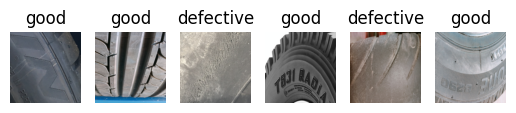

In [72]:
# Visual classification
classes = dataset.classes
print('Visual classification',classes)
for i, (images, labels) in enumerate(train_loader):
    if i > 0:
        break
    for j in range(len(labels)):
        image = images[j]
        label = labels[j]
        image = image.numpy().transpose((1, 2, 0))
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = image * std + mean
        if j > 0 and j <= 6:
            plt.subplot(1, 6, j)
            plt.imshow(image)
            plt.title(classes[label])
            plt.axis('off')
    plt.savefig('Training visualization')
    plt.show()


In [73]:
## network initialization
device = torch.device("cuda:0") # Setting up the device
# if torch.cuda.is_avalable():
#     device = torch.device("cuda:0")
# elif torch.backends.mps.is_avalable():
#     device = torch.device("mps")
if device == "cuda:0":
    torch.cuda.set_per_process_memory_fraction(1.0)

In [74]:
# Initializing the model
model = Net(2).to(device)
with open('Model network structure information.txt', 'w') as f:
    f.write(str(model))

In [12]:
# training

from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # optimizer
# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)
# 训train
model.train()
train_losses = []
train_accs = []

val_losses = []
val_accs = []
best_val_acc = 0.0

for epoch in range(20):  # Number of training rounds
    train_loss = []
    train_acc = []
    print(f"epoch:{epoch} train start")
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        acc = accuracy(predicted, labels)
        train_acc.append(acc)
        train_loss.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
    print(f"epoch:{epoch} val_start")
    val_loss = []
    val_precision = []
    val_recall = []
    val_acc = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels)
            _, predicted = torch.max(pred, 1)
            acc = accuracy(predicted, labels)
            val_acc.append(acc)
            val_loss.append(loss.cpu().detach().numpy())
    scheduler.step(sum(val_loss) / len(val_loss))
    train_losses.append(sum(train_loss) / len(train_loss))
    train_accs.append(sum(train_acc) / len(train_acc))
    val_losses.append(sum(val_loss) / len(val_loss))
    val_accs.append(sum(val_acc) / len(val_acc))
    val_acc_avg = sum(val_acc) / len(val_acc)
    print("epoch:{},train_acc:{},train_loss:{},val_loss:{} val_acc {}".format(epoch,train_accs[-1] ,train_losses[-1],val_losses[-1], val_accs[-1]))
    if val_acc_avg > best_val_acc:
        # Saving the best model
        best_val_acc = val_acc_avg
        torch.save(model.state_dict(), 'model_weights.pth')


epoch:0 train start
epoch:0 val_start
epoch:0,train_acc:0.5735645933014354,train_loss:0.6781579673860632,val_loss:0.5803768634796143 val_acc 0.7395833333333334
epoch:1 train start
epoch:1 val_start
epoch:1,train_acc:0.6497208931419457,train_loss:0.6345058519874464,val_loss:0.5592238853375117 val_acc 0.7604166666666666
epoch:2 train start
epoch:2 val_start
epoch:2,train_acc:0.6949760765550239,train_loss:0.5929383479379581,val_loss:0.5280510485172272 val_acc 0.6770833333333334
epoch:3 train start
epoch:3 val_start
epoch:3,train_acc:0.7442185007974481,train_loss:0.5363742518795734,val_loss:0.46599580844243366 val_acc 0.7604166666666666
epoch:4 train start
epoch:4 val_start
epoch:4,train_acc:0.7507974481658691,train_loss:0.502136035327706,val_loss:0.4072314624985059 val_acc 0.8229166666666666
epoch:5 train start
epoch:5 val_start
epoch:5,train_acc:0.7820972886762361,train_loss:0.4679349258042979,val_loss:0.39642927671472233 val_acc 0.8229166666666666
epoch:6 train start
epoch:6 val_start
e

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

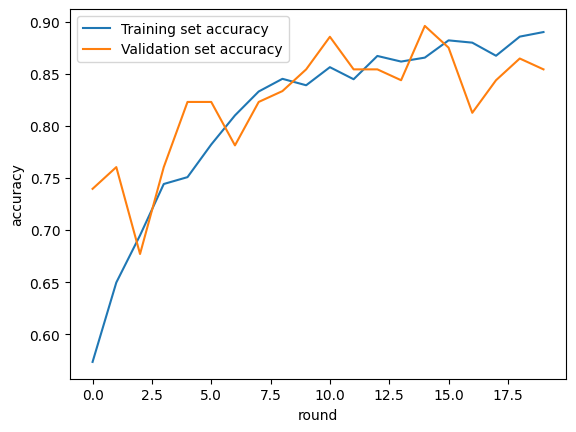

In [13]:
# Accuracy display
plt.plot(train_accs, label='Training set accuracy')
plt.plot(val_accs, label='Validation set accuracy')
plt.xlabel('round')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Training accuracy')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

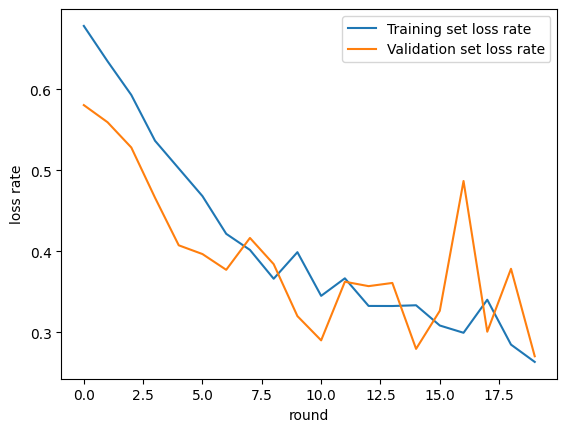

In [14]:
# The loss function
plt.plot(train_losses, label='Training set loss rate')
plt.plot(val_losses, label='Validation set loss rate')
plt.xlabel('round')
plt.ylabel('loss rate')
plt.legend()
plt.savefig('Training loss rate')
plt.show()

In [15]:
model.load_state_dict(torch.load('model_weights.pth'))#Loading the model
model.eval()


y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.cpu().numpy().tolist()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

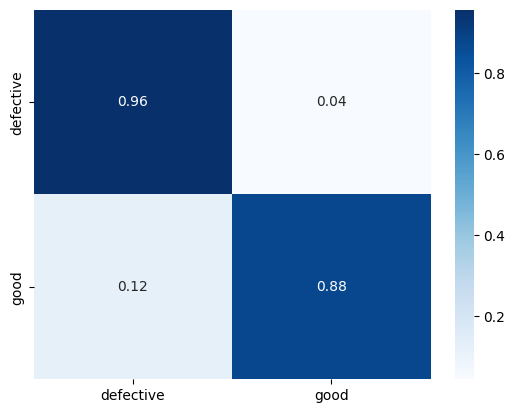

In [16]:
# Plotting the confusion matrix
labels = classes

cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.savefig('Training confusion matrix')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

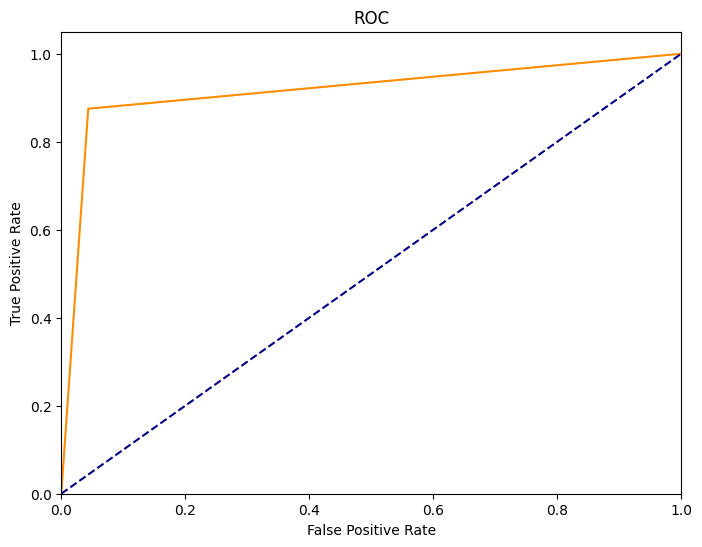

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC ' )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('ROC')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

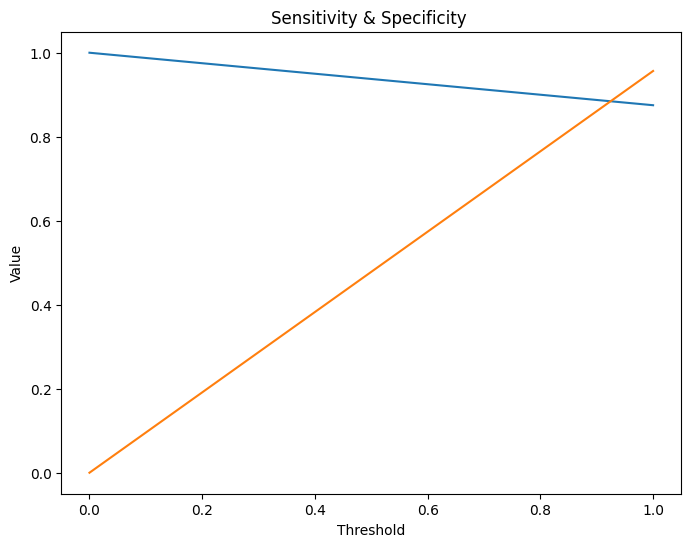

In [18]:
sensitivity = tpr
specificity = 1 - fpr

plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivity, label='Sensitivity')
plt.plot(thresholds, specificity, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Sensitivity & Specificity ')
plt.savefig('Sensitivity & Specificity ')
plt.show()

In [75]:
model = Net(num_classes=2)

# Load the entire model weights
state_dict = torch.load('model_weights.pth')

# The weight dictionary is extracted and modified to fit the structure of the model
normal_model_state_dict = {k.replace('normal_model.', ''): v for k, v in state_dict.items() if 'normal_model.' in k}
residual_model_state_dict = {k.replace('residual_model.', ''): v for k, v in state_dict.items() if 'residual_model.' in k}

# The adjusted weight dictionary is loaded into the respective submodels
model.normal_model.load_state_dict(normal_model_state_dict)
model.residual_model.load_state_dict(residual_model_state_dict)

# Assume that the size of the input tensor is [batch_size, channels, height, width]
input_tensor = torch.randn(1, 3, 224, 224)
output = model(input_tensor)
print(output)


tensor([[-0.0779, -0.1892]], grad_fn=<AddmmBackward0>)


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

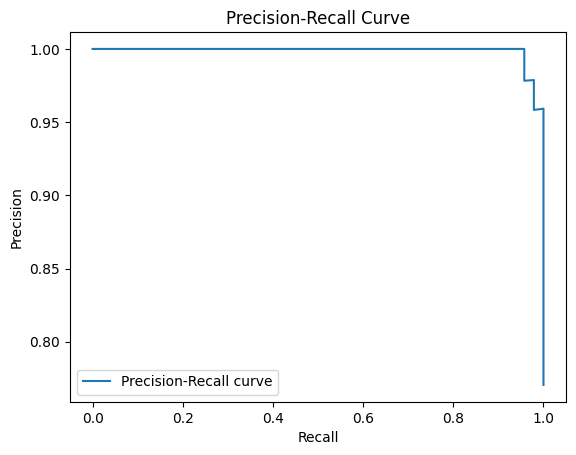

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

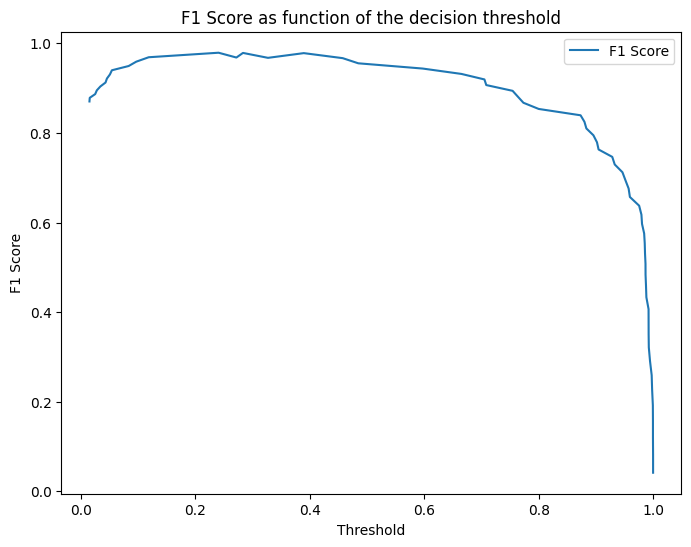

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

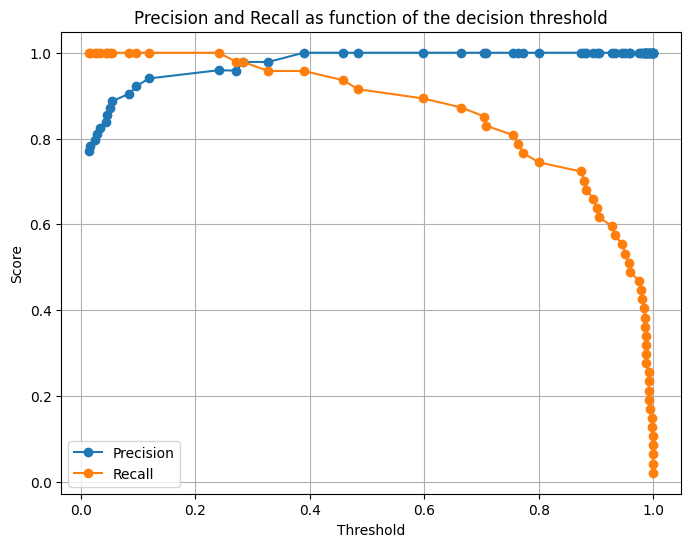

In [77]:
import numpy as np
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

model = Net(num_classes=2) # Make sure num_classes matches the number of classes in the dataset
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # Set to evaluation mode

# Collect model outputs and true labels
y_true = []
y_scores = []

for images, labels in test_loader:
    with torch.no_grad():
        outputs = model(images)  # Get the output of the model
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  
        y_scores.extend(probabilities.numpy())
        y_true.extend(labels.numpy())

# The Precision-Recall curve and the corresponding F1 Score are calculated
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)


plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(thresholds, f1_scores[:-1], label='F1 Score')  # Make sure to align with the threshold
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score as function of the decision threshold')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', marker='o')  
plt.plot(thresholds, recall[:-1], label='Recall', marker='o')  
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall as function of the decision threshold')
plt.legend()
plt.grid(True)
plt.show()






findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

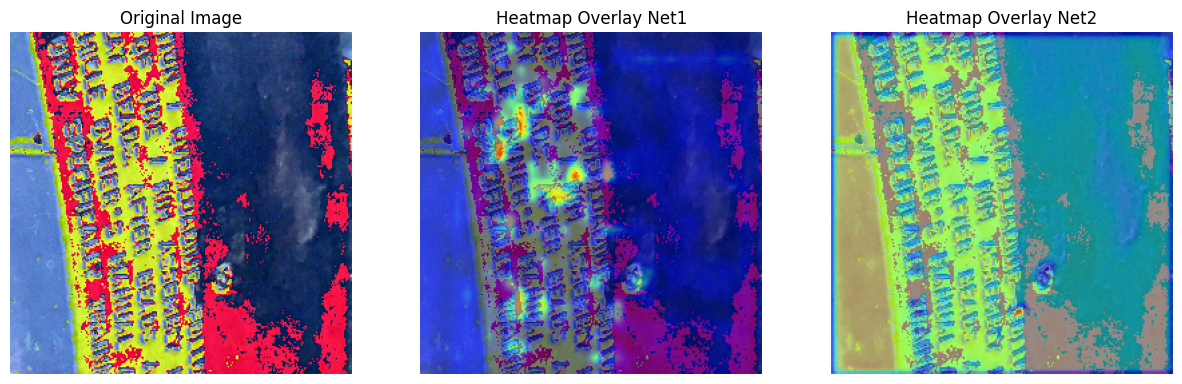

AttributeError: 'SaveOutput' object has no attribute 'remove'

In [89]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from skimage.transform import resize


model.eval()


images, labels = next(iter(test_loader))


index_to_visualize = 0  
original_image = images[index_to_visualize]


target_layer_net1 = list(model.normal_model.features.children())[-2] 
save_output_net1 = SaveOutput(target_layer_net1)


target_layer_net2 = model.residual_model.layer2[-1]
save_output_net2 = SaveOutput(target_layer_net2)


with torch.no_grad():
    _ = model(original_image.unsqueeze(0))


heatmap_net1 = torch.mean(save_output_net1.output, dim=1).squeeze()
heatmap_net1 = torch.relu(heatmap_net1) 
heatmap_net1 = heatmap_net1 / torch.max(heatmap_net1)  


heatmap_net2 = torch.mean(save_output_net2.output, dim=1).squeeze()
heatmap_net2 = torch.relu(heatmap_net2)  
heatmap_net2 = heatmap_net2 / torch.max(heatmap_net2)  


heatmap_resized_net1 = resize(heatmap_net1.cpu().numpy(), (original_image.shape[1], original_image.shape[2]))
heatmap_resized_net2 = resize(heatmap_net2.cpu().numpy(), (original_image.shape[1], original_image.shape[2]))


original_image_vis = to_pil_image(original_image)


plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.imshow(original_image_vis)
plt.title('Original Image')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(original_image_vis)
plt.imshow(heatmap_resized_net1, cmap='jet', alpha=0.5)  
plt.title('Heatmap Overlay Net1')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(original_image_vis)
plt.imshow(heatmap_resized_net2, cmap='jet', alpha=0.5)  
plt.title('Heatmap Overlay Net2')
plt.axis('off')

plt.show()


save_output_net1.remove()
save_output_net2.remove()
